In [34]:
import pandas as pd   
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import shutil
import gc
from pathlib import Path
from tsmoothie.smoother import *
from statistics import mean

# Notebook for preprocessing data from experiments

Set working directory. Default is `experiments_data`.

In [35]:
working_directory = "2GB-7N"

In [36]:
def get_subdirectories(directory=""):
    subdirectories = []
    p = Path(f"./../{working_directory}/{directory}")
    for item in p.glob('*/'):
        if item.suffix not in (['.csv', '.zip']):
            subdirectories.append(directory + "/" + item.name)
    return subdirectories

def get_timestamp_info(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    start_time = data['timestamp'].min()
    stop_time = data['timestamp'].max()

    data['timestamp'] = pd.to_numeric(data['timestamp'])
    mean_interval = mean(data.diff(axis=0)['timestamp'][1:].tolist())
    mean_interval = round(mean_interval / 1000000000, 3)

    return (stop_time - start_time).total_seconds(), mean_interval

def preprocess_file(file_path, save_path, filename, iteration):
    read_data = pd.read_csv(file_path + "/" + filename)
    agg_read_data = read_data.\
        groupby('timestamp', as_index=False).\
        agg({"CPU": "sum", "RAM": "sum"})

    generate_plot(agg_read_data.index, agg_read_data.CPU, "{0}/CPU/{1}_CPU.png".format(save_path, iteration))
    generate_plot(agg_read_data.index, agg_read_data.RAM, "{0}/RAM/{1}_RAM.png".format(save_path, iteration))

    return agg_read_data, get_timestamp_info(agg_read_data)

def generate_plot(data_x="", data_y="", plot_path="", title=""):
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(data_x, data_y, 'r.-')
    plt.title(title)
    plt.savefig(plot_path)
    plt.close(fig)

def create_directory(path):
    try:
        os.mkdir(path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

def smooth_data(mean_data, path, function_name):
        smoother = ConvolutionSmoother(window_len=7, window_type="ones")
        cpu_data = mean_data['CPU']
        ram_data = mean_data['RAM']

        smoother.smooth(cpu_data)
        smooth_cpu_data = smoother.smooth_data[0]
        smoother.smooth(ram_data)
        smooth_ram_data = smoother.smooth_data[0]

        generate_plot(data_x=mean_data.index,
                      data_y=smooth_cpu_data,
                      plot_path="{0}/smooth_mean_CPU.png".format(path),
                      title="Smoothed {0}".format(function_name))
        generate_plot(data_x=mean_data.index,
                      data_y=smooth_ram_data,
                      plot_path="{0}/smooth_mean_RAM.png".format(path),
                      title="Smoothed {0}".format(function_name))

        smooth_data = pd.DataFrame(list(zip(smooth_cpu_data, smooth_ram_data)), columns=['CPU', 'RAM'])
        smooth_data.to_csv("{0}/smooth_mean_data.csv".format(path), index=False)

Check for subdirectories. Number of subdirectories should much the number of nodes used for experiments.

In [37]:
all_directories = get_subdirectories()
nodes_directories = [x for x in all_directories if "node" in x]
nodes_directories

['/node_11',
 '/node_12',
 '/node_13',
 '/node_14',
 '/node_15',
 '/node_16',
 '/node_17',
 '/node_20']

In [38]:
data_directories = []
data_directories_groups = []
for directory in nodes_directories:
    cur_node_subdirectories = get_subdirectories(directory)
    data_directories.append(cur_node_subdirectories)

data_directories_groups = data_directories
data_directories = [item for sublist in data_directories for item in sublist]
data_directories_groups

[['/node_11/avgNetProfitGroupedBySoldDate',
  '/node_11/avgNetProfitGroupedBySoldDateWhereProfitNegative',
  '/node_11/avgNetProfitGroupedBySoldDateWhereYearAfter2000',
  '/node_11/avgWholeSaleCostGroupedBySoldDate',
  '/node_11/countDistinctTicketNumber',
  '/node_11/countNetProfitGroupedBySoldDate',
  '/node_11/countNetProfitGroupedBySoldDateWhereProfitNegative',
  '/node_11/countNetProfitGroupedBySoldDateWhereYearAfter2000',
  '/node_11/countWholeSaleCostGroupedBySoldDate',
  '/node_11/filterCatalogSalesWhereProfitNegative',
  '/node_11/filterCatalogSalesWhereProfitNegativeAndYearAfter2000',
  '/node_11/filterCatalogSalesWhereYearAfter2000',
  '/node_11/filterStoreSalesWhereProfitNegative',
  '/node_11/filterStoreSalesWhereProfitNegativeAndYearAfter2000',
  '/node_11/filterStoreSalesWhereYearAfter2000',
  '/node_11/maxNetProfitGroupedBySoldDate',
  '/node_11/maxNetProfitGroupedBySoldDateWhereProfitNegative',
  '/node_11/maxNetProfitGroupedBySoldDateWhereYearAfter2000',
  '/node_11/m

Check for function names in each node directory.
These names should match the names in `experiments-plan.csv`.


In [39]:
function_names = data_directories_groups[1]
function_names = list(map(lambda x: x[8:], data_directories_groups[1]))
function_names

['/avgNetProfitGroupedBySoldDate',
 '/avgNetProfitGroupedBySoldDateWhereProfitNegative',
 '/avgNetProfitGroupedBySoldDateWhereYearAfter2000',
 '/avgWholeSaleCostGroupedBySoldDate',
 '/countDistinctTicketNumber',
 '/countNetProfitGroupedBySoldDate',
 '/countNetProfitGroupedBySoldDateWhereProfitNegative',
 '/countNetProfitGroupedBySoldDateWhereYearAfter2000',
 '/countWholeSaleCostGroupedBySoldDate',
 '/filterCatalogSalesWhereProfitNegative',
 '/filterCatalogSalesWhereProfitNegativeAndYearAfter2000',
 '/filterCatalogSalesWhereYearAfter2000',
 '/filterStoreSalesWhereProfitNegative',
 '/filterStoreSalesWhereProfitNegativeAndYearAfter2000',
 '/filterStoreSalesWhereYearAfter2000',
 '/maxNetProfitGroupedBySoldDate',
 '/maxNetProfitGroupedBySoldDateWhereProfitNegative',
 '/maxNetProfitGroupedBySoldDateWhereYearAfter2000',
 '/maxWholeSaleCostGroupedBySoldDate',
 '/minNetProfitGroupedBySoldDate',
 '/minNetProfitGroupedBySoldDateWhereProfitNegative',
 '/minNetProfitGroupedBySoldDateWhereYearAfter2

### Aggregating data from all nodes (11-19)

In [40]:
master_dir_index = nodes_directories.index('/node_20')
workers_directories = nodes_directories.copy()
del workers_directories[master_dir_index]

workers_directories

['/node_11',
 '/node_12',
 '/node_13',
 '/node_14',
 '/node_15',
 '/node_16',
 '/node_17']

In [41]:
create_directory(f"./../{working_directory}/preprocessed-data")

mean_dir = f"./../{working_directory}/preprocessed-data/workers-mean-data"
create_directory(mean_dir)
workers_summary = pd.DataFrame(columns=["function_name",
                                             "mean_duration",
                                             "mean_interval",
                                             "nodes_durations",
                                             "nodes_intervals"])

workers_summary.to_csv("{0}/experiments_mean_duration.csv".format(mean_dir), index=False)

Error: ./../2GB-7N/preprocessed-data - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-7N/preprocessed-data/workers-mean-data - Nie można utworzyć pliku, który już istnieje.


In [42]:
def preprocess_selected_function(f_names, workers_summary):
    for function_name in f_names:
        base_data = pd.DataFrame()
        experiment_duration = []
        experiment_interval = []
        nodes_durations = []
        nodes_intervals = []

        experiment_mean_dir = "{0}{1}".format(mean_dir, function_name)
        create_directory(experiment_mean_dir)

        for node_dir in workers_directories:
            file_path = f"./../{working_directory}{node_dir}{function_name}"
            p = Path(file_path)
            plots_path = "{0}/plots".format(file_path)

            create_directory(plots_path)
            create_directory(plots_path + "/RAM")
            create_directory(plots_path + "/CPU")

            experiment_number = 1
            node_intervals = []
            node_durations = []

            for file in p.glob('*.csv'):
                new_data, (duration, interval) = preprocess_file(file_path, plots_path, file.name, experiment_number)
                base_data = pd.concat((base_data, new_data))

                experiment_duration.append(duration)
                experiment_interval.append(interval)
                node_intervals.append(interval)
                node_durations.append(duration)

                experiment_number += 1

            print("{0} | {1} durations: {2}".format(function_name[1:], node_dir[1:], node_durations))

            nodes_intervals.append((node_dir[1:], round(mean(node_intervals), 3)))
            nodes_durations.append((node_dir[1:], round(mean(node_durations), 3)))

        mean_interval = round(mean(experiment_interval), 3)

        base_data["timestamp"] = base_data.apply(lambda row: mean_interval * row.name, axis = 1)
        base_data = base_data.groupby(base_data.index).mean()
        base_data.to_csv("{0}/mean_data.csv".format(experiment_mean_dir), index=False)

        generate_plot(base_data.index, base_data.CPU, "{0}/mean_CPU.png".format(experiment_mean_dir), function_name[1:] + " CPU")
        generate_plot(base_data.index, base_data.RAM, "{0}/mean_RAM.png".format(experiment_mean_dir), function_name[1:] + " RAM")

        # smooth_data(base_data, experiment_mean_dir, function_name)
        workers_summary = workers_summary.append({"function_name": function_name[1:],
                                                            "mean_duration": round(mean(experiment_duration), 3),
                                                            "mean_interval": mean_interval,
                                                            "nodes_durations": nodes_durations,
                                                            "nodes_intervals": nodes_intervals}, ignore_index=True)

    workers_summary.to_csv("{0}/experiments_mean_duration.csv".format(mean_dir), index=False, mode="a", header=False)

    del base_data
    del experiment_interval
    del experiment_duration
    del nodes_durations
    del nodes_intervals
    del new_data
    del node_intervals
    del node_durations
    del workers_summary
    gc.collect()

In [43]:
print(f"Functions: {len(function_names)}")

Functions: 29


In [44]:
preprocess_selected_function(function_names[0:4], workers_summary)

Error: ./../2GB-7N/preprocessed-data/workers-mean-data/avgNetProfitGroupedBySoldDate - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-7N/node_11/avgNetProfitGroupedBySoldDate/plots - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-7N/node_11/avgNetProfitGroupedBySoldDate/plots/RAM - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-7N/node_11/avgNetProfitGroupedBySoldDate/plots/CPU - Nie można utworzyć pliku, który już istnieje.
avgNetProfitGroupedBySoldDate | node_11 durations: [159.686872, 197.066502, 171.631743, 260.043755, 262.087055, 182.635314, 259.87533, 265.556478, 199.158209, 261.914677, 265.68328, 187.670128, 191.286303, 185.943335, 182.641714, 149.287882, 192.138398, 190.970412, 181.633067, 263.659356, 169.884794, 170.563387, 263.955449, 188.919251, 201.45631]
Error: ./../2GB-7N/node_12/avgNetProfitGroupedBySoldDate/plots - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-7N/node_12/avgNetProfitGroupedBySoldDate/plots/RAM

In [45]:
gc.collect()

3820825

countDistinctTicketNumber | node_11 durations: [14293.021701]
countDistinctTicketNumber | node_12 durations: [14306.142132]
countDistinctTicketNumber | node_13 durations: [14321.122873]
countDistinctTicketNumber | node_14 durations: [14328.245443]
countDistinctTicketNumber | node_15 durations: [14347.779445]
countDistinctTicketNumber | node_16 durations: [14354.741218]
countDistinctTicketNumber | node_17 durations: [14365.340233]
countNetProfitGroupedBySoldDate | node_11 durations: [258.794085, 264.926348, 272.013215, 190.398921, 185.056001, 201.97428, 187.724772, 185.080028, 184.915228, 163.783363, 184.962756, 248.470512, 190.782365, 265.41318, 260.847476, 184.020746, 197.501603, 186.924178, 257.742843, 275.038828, 180.870353, 260.095956, 149.291455, 257.565171, 191.749704]
countNetProfitGroupedBySoldDate | node_12 durations: [258.636164, 264.838114, 271.851284, 190.333658, 184.92823, 201.783937, 187.606673, 185.016825, 184.693307, 163.706428, 184.75498, 248.239086, 190.75495, 265.314

KeyboardInterrupt: 

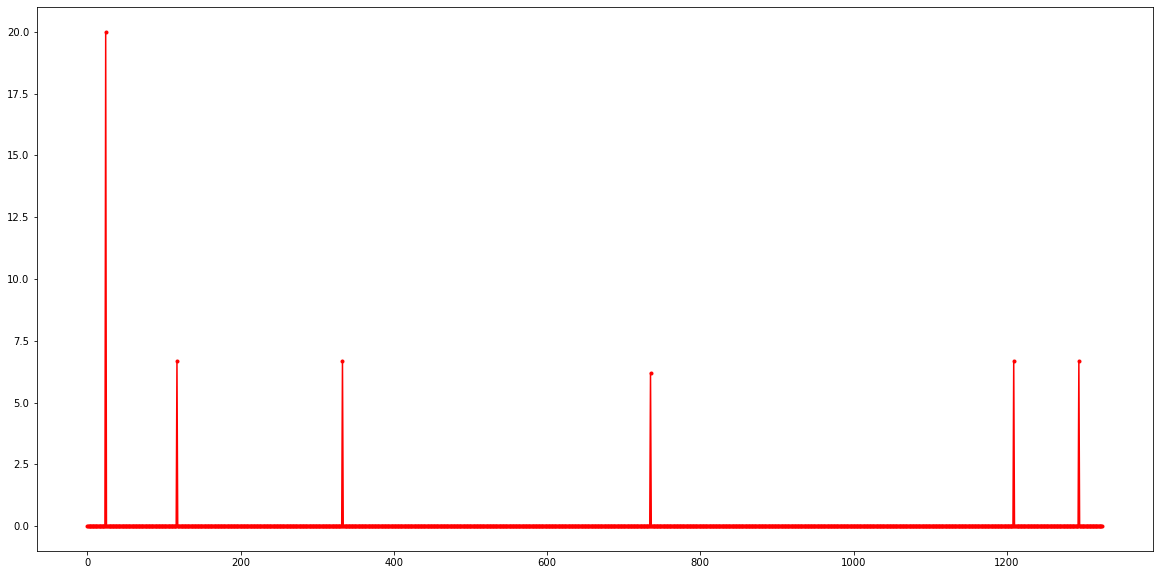

In [46]:
preprocess_selected_function(function_names[4:8], workers_summary)

In [ ]:
gc.collect()

In [ ]:
preprocess_selected_function(function_names[8:12], workers_summary)

In [ ]:
gc.collect()

In [ ]:
preprocess_selected_function(function_names[12:16], workers_summary)

In [ ]:
gc.collect()

In [ ]:
preprocess_selected_function(function_names[16:20], workers_summary)

In [ ]:
gc.collect()

In [ ]:
preprocess_selected_function(function_names[20:24], workers_summary)

In [ ]:
gc.collect()

In [ ]:
preprocess_selected_function(function_names[24:28], workers_summary)

In [ ]:
gc.collect()

In [ ]:
preprocess_selected_function(function_names[28:], workers_summary)

In [ ]:
gc.collect()

### Aggregating data from master node #20

In [ ]:
create_directory(f"./../{working_directory}/preprocessed-data")

master_dir = f"./../{working_directory}/preprocessed-data/master-mean-data"
create_directory(master_dir)
master_mean_summary = pd.DataFrame(columns=["function_name",
                                            "mean_duration",
                                            "mean_interval"])

print("Progress:")
for function in function_names:
    files_path = f"./../{working_directory}/node_20{function}"
    p = Path(files_path)
    master_data = pd.DataFrame()

    experiment_durations = []
    experiment_intervals = []

    master_experiment_directory = "{0}{1}".format(master_dir, function)
    master_plot_directory = "{0}/plots".format(files_path)

    create_directory(master_experiment_directory)
    create_directory(master_plot_directory)
    create_directory("{0}/CPU".format(master_plot_directory))
    create_directory("{0}/RAM".format(master_plot_directory))

    experiment_number = 1
    for file in p.glob('*.csv'):
        master_new_data, (duration, interval) = preprocess_file(files_path, master_plot_directory, file.name, experiment_number)
        master_data = pd.concat((master_data, master_new_data))
        experiment_durations.append(duration)
        experiment_intervals.append(interval)
        experiment_number += 1

    master_mean_summary = master_mean_summary.append({"function_name": function[1:],
                                                      "mean_duration": round(mean(experiment_durations), 3),
                                                      "mean_interval": round(mean(experiment_intervals), 3)},
                                                     ignore_index=True)

    master_data = master_data.groupby(master_data.index).mean()
    master_data.to_csv("{0}/mean_data.csv".format(master_experiment_directory), index=False)

    generate_plot(master_data.index, master_data.CPU, "{0}/mean_CPU.png".format(master_experiment_directory))
    generate_plot(master_data.index, master_data.RAM, "{0}/mean_RAM.png".format(master_experiment_directory))

    smooth_data(master_data, master_experiment_directory, function[1:])
    print("- {0} - done".format(function[1:]))

    # Deleting variables
    del master_data
    del experiment_intervals
    del experiment_durations
    del master_new_data

master_mean_summary.to_csv("{0}/experiments_mean_duration.csv".format(master_dir), index=False)

del master_mean_summary
gc.collect()

### Preprocessing spark internal metrics

Stage and task metrics

In [ ]:
stage_metrics_all = pd.read_csv(f"./../{working_directory}/stage_metrics.csv")
task_metrics_all = pd.read_csv(f"./../{working_directory}/task_metrics.csv")

stage_metrics = stage_metrics_all[["function_name", "stage_id", "num_tasks", "executor_run_time", "result_size"]].copy()
stage_metrics["stage_time"]= stage_metrics_all["completion_time"] - stage_metrics_all["submission_time"]
stage_metrics = stage_metrics.groupby(["function_name", "stage_id"]).agg({
    "stage_time": "mean",
    "num_tasks": "max",
    "executor_run_time": "mean",
    "result_size": "mean"
})

task_metrics = task_metrics_all[["function_name", "stage_id", "task_type"]]
task_metrics = task_metrics.groupby(["function_name", "stage_id"]).agg({"task_type": "unique"})

spark_metrics = task_metrics.join(stage_metrics).reset_index().rename(columns={
    "stage_time": "mean_stage_time",
    "task_type": "task_types",
    "executor_run_time": "mean_executor_run_time",
    "result_size": "mean_result_size"
})

spark_metrics.to_csv(f"./../{working_directory}/preprocessed-data/spark_metrics.csv", index=False)
spark_metrics

### Clear preprocessed data

In [ ]:
for function_name in function_names:
    for node_dir in nodes_directories:
        try:
            shutil.rmtree(f"./../{working_directory}{node_dir}{function_name}/plots")
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))

try:
    shutil.rmtree(f"./../{working_directory}/preprocessed-data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


Clear smoothed data

In [32]:
for function_name in function_names:
    try:
        os.remove(f'./../experiments_data/preprocessed-data/workers-mean-data{function_name}/smooth_mean_CPU.png')
        os.remove(f'./../experiments_data/preprocessed-data/workers-mean-data{function_name}/smooth_mean_data.csv')
        os.remove(f'./../experiments_data/preprocessed-data/workers-mean-data{function_name}/smooth_mean_RAM.png')
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))